# Анализ покупательской активности клиентов интернет-магазина "В один клик"

В этом проекте нам предстоит построить модель калссификации, которая поможет интернет - магазину "В один клик" определять клиентов с высокой вероятностью снижения покупательской активности в следующие три месяца. Помимо этого, необходимо предложить подход к анализу и созданию персонализированных предложений, как сохранить активность клиентов на высоком уровне.  

Для решения поставленной задачи интернет магазин "В один клик" предоставил нам набор данных о клиентах и их активности. Данные включают в себя следующие аспекты:  
- данные о поведении клиента на сайте, 
- данные о продуктовом поведении клиента,
- данные о финансовом поведении клиента,
- данные о маркетинговой коммуникации с клиентом  

Прежде чем приступать к построению модели, нам предстоит провести предварительный анализ данных, включающий в себя:  
- предобработку данных (проверку типов данных, наличие пропусков и дубликатов). 
- исследовательский анализ данных (поиск аномальных значений, анализ распределений переменных, выделение нелинейных связей)  
- корреляционный анализ (анализ логичности взаимосвязей переменных, повера мультиколлинеарности). 

После проведение предвариельных этапов мы сможем приступить к построению модели.
Нам предстоит классифицировать пользователей по двум категориям, для этого будем выбирать из следующих моделей:  
- Логистическая регрессия
- Метод опорных векторов
- К ближайших соседей
- Решающее дерево

Помимо самих моделей, мы будем перебирать различные варианты гиперпараметров (в первую очень для оптимального контроля переобучения), а также варианты кодировок категориальных переменных и масштабирования количественных.  
После обучения оптимальной модели мы сделаем вывод о влиянии различных факторов на вероятность снижения покупательской активности клиента.  

Наконец, на основе предсказанных лучшей моделью вероятностей снижения клиентской активнсоти мы сможем сгруппировать клиентов с учетом прибыли, которую они приносят компании. Далее, мы выберем один сегмент и проанализируем, какими действиями можно сохранить покупательскую активность клиентов на высоком уровне.

## Загрузка данных

In [1]:
# Установим необходимые сторонние библиотеки
! pip install phik
! pip install shap 
! pip install -U scikit-learn -q # -q убирает необязательные выводы в командах Linux

In [2]:
# Импортируем базовые необходимыебиблиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.set_option('display.max_colwidth', None)

# Импортируем функции для построения пайплайнов и подготовки данных к обчению моделей
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Импортируем небходимые модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Импортируем классы подбора гиперпараметров моделей
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Импортируем возможные метрики анализа качества моделей
from sklearn.metrics import accuracy_score,f1_score

# Импортируем сторонние библиотеки
import phik
import shap

In [3]:
# Загрузим все необходимые наборы данных

market_file_df = pd.read_csv('/datasets/market_file.csv')
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', sep = ';',decimal=",")

In [4]:
display(market_file_df.head(3))
market_file_df.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
display(market_money_df.head(3))
market_money_df.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
display(market_time_df.head(3))
market_time_df.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
display(money_df.head(3))
money_df.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Итак, мы импортировали все необходимые для решения задачи библиотеки, а также загрузили наборы исходных данных для построения модели.  
Все данные соответствуют описанию, форматы данных определились корректно.

## Предобработка данных

На предыдущем этапе мы убедились, что все типы данных определились корректно.  
Теперь провеим данные на наличие пропусков.

In [8]:
market_file_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [9]:
market_money_df.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [10]:
market_time_df.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [11]:
money_df.isna().sum()

id         0
Прибыль    0
dtype: int64

Явные пропуски в наборах данных отсутствуют.

Проверим данные на наличие дубликатов. Для начала попробуем идентифицировать скрытые дубликаты - рассмотрим уникальные значения категориальных атрибутов.

In [12]:
print(market_file_df['Покупательская активность'].unique())
print(market_file_df['Тип сервиса'].unique())
print(market_file_df['Разрешить сообщать'].unique())
print(market_file_df['Популярная_категория'].unique())

print(market_money_df['Период'].unique())

print(market_time_df['Период'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']


Видим неявный дубликат в переменной *Тип сервиса* - опечатка "стандартт". Заменим на корректный вариант "стандарт".  
Кроме этого, видим опеатку в переменной *Период* набора данных market_time_df. Заменим "предыдцщий_месяц" на "предыдущий_месяц"..

In [13]:
print(market_file_df['Тип сервиса'].value_counts())

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64


In [14]:
# Проведем замены
market_file_df['Тип сервиса'] = np.where(market_file_df['Тип сервиса']=="стандартт",
                                        'стандарт',
                                        market_file_df['Тип сервиса'])
market_time_df['Период'] = np.where(market_time_df['Период']=='предыдцщий_месяц',
                                   'предыдущий_месяц',
                                   market_time_df['Период'])

In [15]:
# Проверим себя
print(market_file_df['Тип сервиса'].unique())
print(market_time_df['Период'].unique())

['премиум' 'стандарт']
['текущий_месяц' 'предыдущий_месяц']


Итак, мы избавились от опечаток и неявных дубликтов. Теперь проверим данные на наличие явных дубликатов.

In [16]:
print(f"Явных дубликатов в наборе данных market_file_df: {market_file_df.duplicated().sum()}")
print(f"Явных дубликатов в наборе данных market_money_df: {market_money_df.duplicated().sum()}")
print(f"Явных дубликатов в наборе данных market_time_df: {market_time_df.duplicated().sum()}")
print(f"Явных дубликатов в наборе данных money_df: {money_df.duplicated().sum()}")

Явных дубликатов в наборе данных market_file_df: 0
Явных дубликатов в наборе данных market_money_df: 0
Явных дубликатов в наборе данных market_time_df: 0
Явных дубликатов в наборе данных money_df: 0


Отдельно убедимся, что в основном наборе данных одному уникальному клиенту соответсвтует лишь одна строка:

In [17]:
print(f"Максимальное количество строк на одного клиента: {max(market_file_df['id'].value_counts())}")

Максимальное количество строк на одного клиента: 1


После загрузки данных мы провели предобработку:  
- удостоверились, что типы данных корректны  
- убедились, что в основном наборе данных (market_file_df) набор клиентов уникален - каждому клиенту соответствует только одна строка
- проверили, что в данных отсутствуют пропуски  
- убедлись, что в данных отсутствуют явные дубликаты
- избавились от 10 неянвых дубликатов в переменной *Тип сервиса* - опечатка "стандартт"  
- исправили опечатку в переменной *Период* набора данных market_time_df - предыдцщий_месяц на предыдущий_месяц

## Исследовательский анализ данных

Для начала рассмотрим распределение нашей целевой переменной 'Покупательская активность', а также других бинарных переменных (принимающих два уникальных значения) - 'Тип сервиса' и 'Разрешить сообщать'.

[]

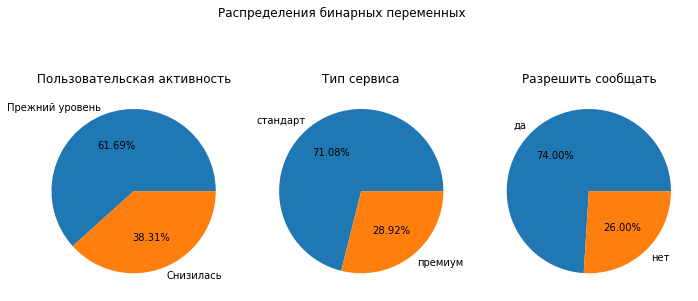

In [18]:
fix, axes = plt.subplots(1,3,figsize = (10,5))

axes[0].pie(market_file_df['Покупательская активность'].value_counts(),
            autopct='%1.2f%%',
            labels = market_file_df['Покупательская активность'].value_counts().index)
axes[0].set_title('Пользовательская активность')

axes[1].pie(market_file_df['Тип сервиса'].value_counts(),
            autopct='%1.2f%%',
            labels = market_file_df['Тип сервиса'].value_counts().index)
axes[1].set_title('Тип сервиса')

axes[2].pie(market_file_df['Разрешить сообщать'].value_counts(),
            autopct='%1.2f%%',
            labels = market_file_df['Разрешить сообщать'].value_counts().index)
axes[2].set_title('Разрешить сообщать')

plt.suptitle('Распределения бинарных переменных')

plt.tight_layout()
plt.plot()

Итак, мы видим, что с точки зрения целевой переменной классы не сбалансированы. Доля клиентов с будущим значением целевой переменной 1 (снизилась пользоватлеьская активность) составляет порядка 38%. Дисбаланс классов не является критичным, в целом довольно близок к равному соотношению. Тем не менее, мы все равно учтем его при разбиении данных на тренировочную и тестовую выборки.

Две другие бинарные переменные ('Тип сервиса' и 'Разрешить сообщать') распределены более неравномерно - доминирующий класс преобладает в соотношении примерно 3:1. Это не является проблемой.

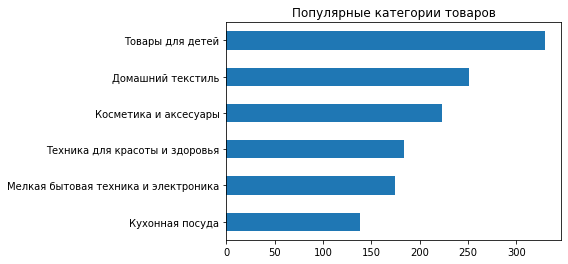

In [19]:
# Рассмотрим категориальную переменную Популярная_категория

market_file_df['Популярная_категория'].value_counts().sort_values().plot.barh()
plt.title('Популярные категории товаров')
plt.show()

Мы видим, что все товары распределены на 6 категорий, из которых наибольшей популярностью пользуются товары для детей, а наименьшей - кухонная посуда. Хоть размеры категорий не равны, в целом они сопоставимы и не должны вызвать проблем при построении моделей.

Теперь рассмотрим все оставшиеся каоличественные переменные из набора данных market_file_df, а также коичественные переменные из других наборов: market_money_df, market_time_df, money_df.

In [20]:
pd.concat([market_file_df.describe(),
           market_money_df['Выручка'].describe(),
           market_time_df['минут'].describe(),
           money_df['Прибыль'].describe()],axis=1)

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка,минут,Прибыль
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,3900.000000,2600.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,5025.696051,13.336154,3.996631
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,1777.704104,4.080198,1.013722
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,4.000000,0.860000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,4590.150000,10.000000,3.300000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,4957.500000,13.000000,4.045000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,5363.000000,16.000000,4.670000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,106862.200000,23.000000,7.430000


[]

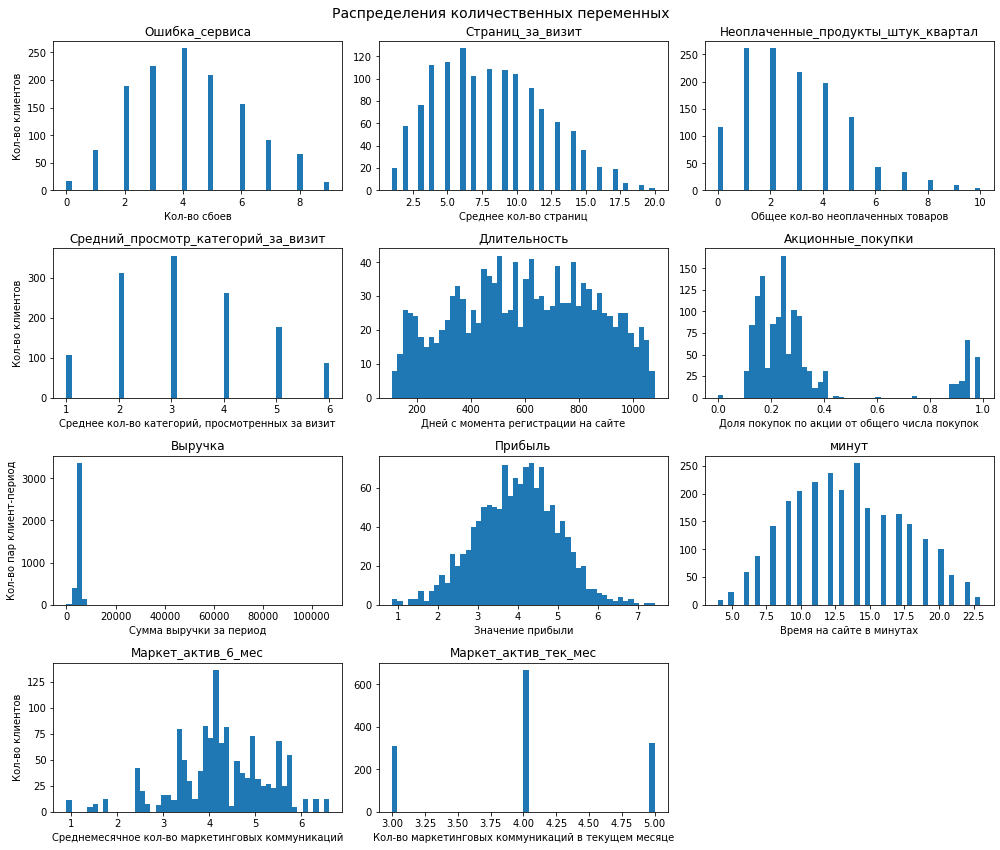

In [21]:
fix, axes = plt.subplots(4,3,figsize = (14,12))

axes[0,0].hist(market_file_df['Ошибка_сервиса'], bins = 50)
axes[0,0].set_title('Ошибка_сервиса')
axes[0,0].set_ylabel('Кол-во клиентов')
axes[0,0].set_xlabel('Кол-во сбоев')

axes[0,1].hist(market_file_df['Страниц_за_визит'], bins = 50)
axes[0,1].set_title('Страниц_за_визит')
axes[0,1].set_xlabel('Среднее кол-во страниц')

axes[0,2].hist(market_file_df['Неоплаченные_продукты_штук_квартал'], bins = 50)
axes[0,2].set_title('Неоплаченные_продукты_штук_квартал')
axes[0,2].set_xlabel('Общее кол-во неоплаченных товаров')

axes[1,0].hist(market_file_df['Средний_просмотр_категорий_за_визит'], bins = 50)
axes[1,0].set_title('Средний_просмотр_категорий_за_визит')
axes[1,0].set_ylabel('Кол-во клиентов')
axes[1,0].set_xlabel('Среднее кол-во категорий, просмотренных за визит')

axes[1,1].hist(market_file_df['Длительность'], bins = 50)
axes[1,1].set_title('Длительность')
axes[1,1].set_xlabel('Дней с момента регистрации на сайте')

axes[1,2].hist(market_file_df['Акционные_покупки'], bins = 50)
axes[1,2].set_title('Акционные_покупки')
axes[1,2].set_xlabel('Доля покупок по акции от общего числа покупок')

axes[2,0].hist(market_money_df['Выручка'], bins = 50)
axes[2,0].set_title('Выручка')
axes[2,0].set_ylabel('Кол-во пар клиент-период')
axes[2,0].set_xlabel('Сумма выручки за период')

axes[2,1].hist(money_df['Прибыль'], bins = 50)
axes[2,1].set_title('Прибыль')
axes[2,1].set_xlabel('Значение прибыли')

axes[2,2].hist(market_time_df['минут'], bins = 50)
axes[2,2].set_title('минут')
axes[2,2].set_xlabel('Время на сайте в минутах')

axes[3,0].hist(market_file_df['Маркет_актив_6_мес'], bins = 50)
axes[3,0].set_title('Маркет_актив_6_мес')
axes[3,0].set_ylabel('Кол-во клиентов')
axes[3,0].set_xlabel('Среднемесячное кол-во маркетинговых коммуникаций')

axes[3,1].hist(market_file_df['Маркет_актив_тек_мес'], bins = 50)
axes[3,1].set_title('Маркет_актив_тек_мес')
axes[3,1].set_xlabel('Кол-во маркетинговых коммуникаций в текущем месяце')

axes[3,2].axis('off')

plt.suptitle('Распределения количественных переменных', fontsize = 14)

plt.tight_layout()
plt.plot()

Итак, мы можем заметить, что большинство переменных демонстрируют равномерные либо близкие к нормальным характеры распределений.

Отдельно хочется остановиться на нескольких моментах:  
- Переменная *Акционные_покупки* имеет ярко выраженное бимодальное распределение, возможно в будущем нам будет необходимо заменить ее на бинарную переменную, которая принимает значения 1 если клиент совершает большинство покупок только по акции, и значение 0 - в остальных случаях.  
- Переменная *Маркет_актив_6_мес* показывает фрагментированное распредление, рассмотрим ее дополнительно.
- Переменная *Выручка* имеет очевидные аномальные значения, рассмотрим их отдельно.

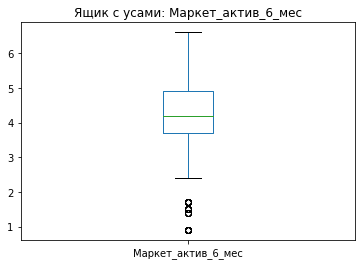

In [22]:
# Построим "ящик с усами" для переменной 'Маркет_актив_6_мес'

market_file_df['Маркет_актив_6_мес'].plot.box()
plt.title('Ящик с усами: Маркет_актив_6_мес')
plt.show()

Мы в видим, что в переменной действительно присуствуют выбросы со статистической точки зрения, однако данные значения не являются аномальными, поэтому оставим переменную без изменений.

In [23]:
# Рассмотрим аномальные значения переменной Выручка

market_money_df[market_money_df['Выручка']>10000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Итак, мы действительно видим очень подозрительного клиента, выручка от которого составила более 100 000.
Попробуем оценить, является ли это технической ошибкой в данных или правдой.

In [24]:
display(market_money_df[market_money_df['id']==215380])
display(market_file_df[market_file_df['id']==215380])
display(market_time_df[market_time_df['id']==215380])
money_df[money_df['id']==215380]

,id,Период,Выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


,id,Период,минут
64,215380,предыдущий_месяц,12
65,215380,текущий_месяц,14


,id,Прибыль
32,215380,3.88


Так мы видим, чо данный клиент не выделяется ничем примечательным по остальным показателям - является абсолютно "средним" клиентом, который предпочитает покупать товары по акции.

Данные по выручке за предыдущие периоды также не выделяются ничем странным и находят примерно на уровне среднего значения около 5000.

В связи с этим, заменим выручку клиента 215380 на медианное значение (в данном случае эквивалетно среднему) между его показателями вырчки за 2 предыдщих периода.

In [25]:
market_money_df.loc[market_money_df['id']==215380,'Выручка'] = market_money_df[(market_money_df['id']==215380)&
                (market_money_df['Период'].isin(['препредыдущий_месяц','предыдущий_месяц']))]['Выручка'].mean()

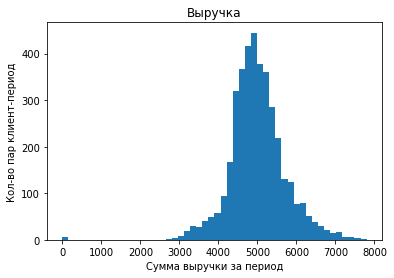

In [26]:
# Еще раз посмотрим на рапсредлеение
plt.hist(market_money_df['Выручка'], bins = 50)
plt.title('Выручка')
plt.ylabel('Кол-во пар клиент-период')
plt.xlabel('Сумма выручки за период')
plt.show()

Теперь мы видим, что распределение в целом визуально очень сильно напоминает нормальное, однако присутствуют несколько наблюдений с нулевой выручкой.

In [27]:
market_money_df[market_money_df['Выручка']<2000]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Мы видим, что эти 3 клиента принесли нулевую выручку за 2 предыдущих периода, иными словами - ничего не покупали.

Для дальнейшего анализа мы отберем только таких клиентов, которые имели покупательскую активность не менее трех месяцев или, иными словами, принесли ненулевую выручку в каждый их трех месяцев.

In [28]:
# Пойдем от обратного и отберем таких клиентов, которые хотя бы в одном месяце принесли нулевую выручку

ids_to_remove = (market_money_df.groupby('id')['Выручка'].min()
                 [market_money_df.groupby('id')['Выручка'].min()==0].index)
ids_to_remove

Int64Index([215348, 215357, 215359], dtype='int64', name='id')

Мы видим как раз определенных выше трех клиентов, удалим данные о них из всех наборов данных.

In [29]:
market_file_df = market_file_df[~market_file_df['id'].isin(ids_to_remove)].reset_index(drop=True)
market_money_df = market_money_df[~market_money_df['id'].isin(ids_to_remove)].reset_index(drop=True)
market_time_df = market_time_df[~market_time_df['id'].isin(ids_to_remove)].reset_index(drop=True)
money_df = money_df[~money_df['id'].isin(ids_to_remove)].reset_index(drop=True)

Итак, мы провели исследовательский анализ предоставленных данных:  
- Выяснили, что целевой признак немного несбалансирован, учтем это при разбиении выборки на тренировочную и тестовую.  
- Рассмотрели распределения других категориальных переменных. Распределения также неравномерны, но это не препятствует дальнейшему анализу.
- Удостоверились, что практически все количественные переменные имеют распределения равномерные или напоминающие нормальное.  
- Определили, что переменная *Акционные_покупки* может быть заменена на бинарную переменную.
- Выявили одно аномальное наблдение выручки по клиенту за текущий период, заменили на медианное (среднее) от двух предыдущих периодов.  
- Исключили информацию о трех клиентах, покупательская активность которых составляет менее трех месяцев.

## Объединение таблиц

Ранее мы выяснили, что в основном наборе данных market_file_df каждому клиенту соответствует одна строка с описанием.  
В свою очередь, в таблицах market_money_df и market_time_df структура данных немного отличается и одному клиенту соответствует несколько строк, относящих к разным периодам.

Для объединения всех данных в одну таблицу мы преобразуем данные таким образом, чтобы каждому клиенту соответствовала одна строчка, а разным периодам - отдельные столбцы.

In [30]:
# Трансформируем датафрейм market_time чтобы для каждого клиента в отдальном столбце распологались
# данные о временя, проведенном на сайте, за текущий и предыдущий месяц

market_time_df = market_time_df.pivot(columns = 'Период', index = 'id').reset_index()
market_time_df.columns = ['id','минут_предыдущий_месяц', 'минут_текущий_месяц']

In [31]:
# Трансформируем датафрейм market_money_df чтобы для каждого клиента в отдальном столбце распологались
# данные о выручке за текущий, предыдущий и предпредыдущий месяц

market_money_df = market_money_df.pivot(columns = 'Период', index = 'id').reset_index()
market_money_df.columns = ['id','выручка_предыдущий_месяц','выручка_препредыдущий_месяц', 'выручка_текущий_месяц']

Теперь можем приступать к объединению таблиц.

In [32]:
full_df = (market_file_df.
           merge(market_money_df, on = 'id', how = 'left').
           merge(market_time_df, on = 'id', how = 'left').
           merge(money_df, on = 'id', how = 'left')
          )

In [33]:
# Взглянем на получившийся датафрейм
full_df.tail()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,4.44
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,6.11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,3.29
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,4.03
1296,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,4720.0,5183.0,4448.3,15,10,3.28


Мы провели необходимые преобразования данных - создали отедльные столбцы для разных периодов и убедились, что во всех наборах данных каждому клиенту соответствует одна строка - и объединили все источники данных в одну итоговую таблицу.

## Корреляционный анализ

Для начала, как выяснили во время исследовательского анализа данных, создадим новую переменну:

In [34]:
full_df['Предпочитает_акции'] = np.where(full_df['Акционные_покупки']>0.5, 1, 0)
full_df['Предпочитает_акции'].value_counts()

0    1129
1     168
Name: Предпочитает_акции, dtype: int64

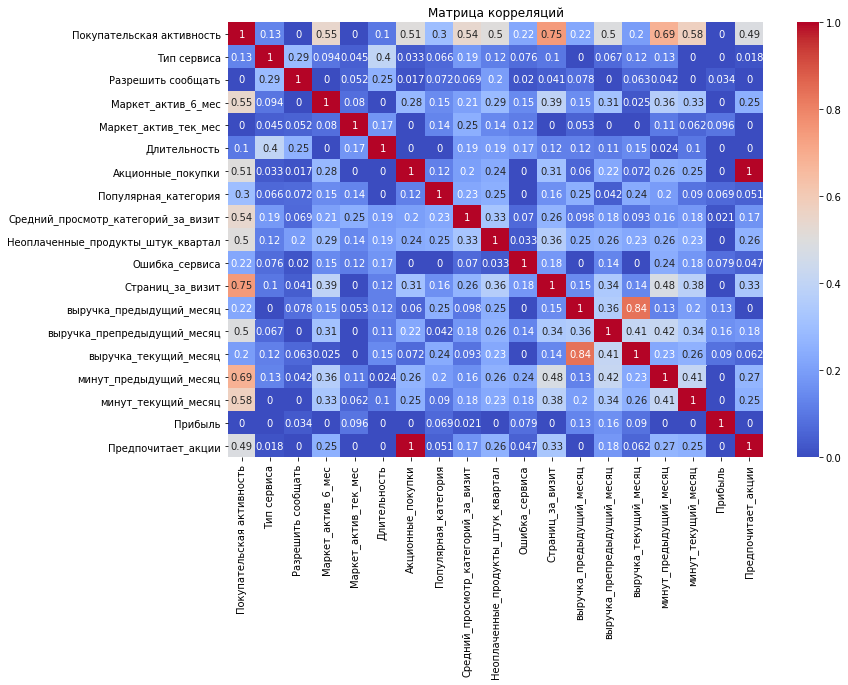

In [35]:
# Определим количественные переменные в явном виде для phik_matrix
interval_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки','Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц', 'Прибыль']


# Построим корреляционную матрицу
plt.figure(figsize = (12,8))
sns.heatmap(full_df.drop(columns='id').phik_matrix(interval_cols=interval_cols),annot = True,cmap='coolwarm')
plt.title('Матрица корреляций')

plt.show()

Итак, вы видим, что наиболее сильная корреляция наблюдается между целевой переменной Покупательская активность и переменными предпочитает_акции, минут_текущий_месяц, минут_предыдущий_месяц, выручка_препредыдущий_месяц, страниц_за_визит, неоплаченные_продукты_штук_квартал, средний_просмотр_категорий_за_визит, акционные_покупки, маркет_актив_6_м. В остальном, в наборе данных между остальными переменными отсутствуют сильные корреляционные связи, за исключением переменных *выручка_предыдущий_месяц* и *выручка_текущий_месяц*. Связь между переменными очень сильная. В целом это логично - размер выручки говорит о том, что клиент крупный, активно пользуется сервисом и приносит много выручки компании. Если клиент уже был крупным в прошлом месяце, логична связь с тем, что он крупный в этом месяце. Хотя мы бы и ожидали меньшего значения коэффициента корреляции.
На предыдущем и препредыдущем периоде также наблюдается связь, но меньшей силы.

Также, ожидаемо, видим полную связь между переменными *Акционные_покупки* и *Предпочитает_акции*

Дополнитльно посмотрим, сохраняется ли структура корреляций для двух целевых категорий клиентов (для тех, у кого снизилаь покупательская активность и для тех, у кого осталась неизменной).

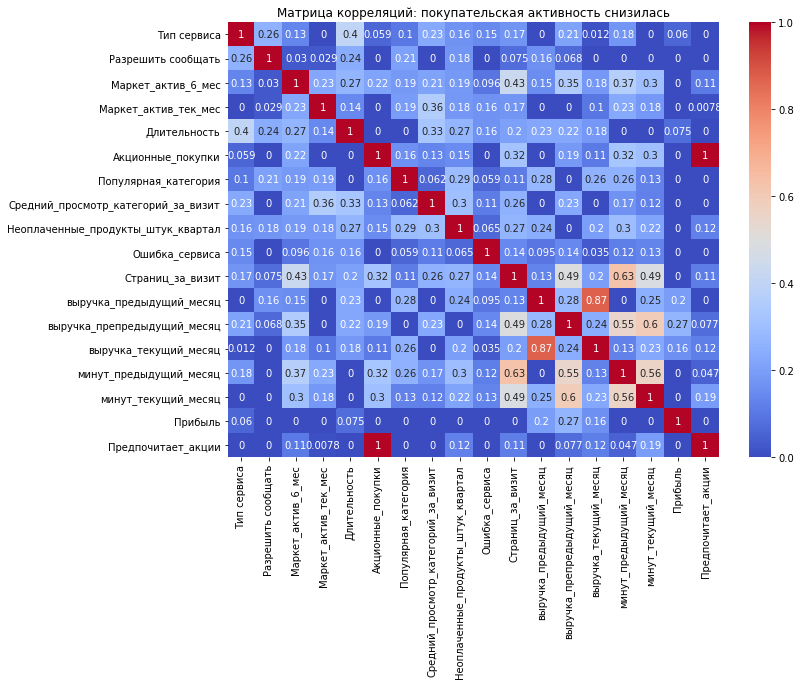

In [36]:
plt.figure(figsize = (11,8))
sns.heatmap(full_df[full_df['Покупательская активность']=='Снизилась'].
            drop(columns=['id','Покупательская активность']).
            phik_matrix(interval_cols=interval_cols),annot = True,cmap='coolwarm')
plt.title('Матрица корреляций: покупательская активность снизилась')

plt.show()

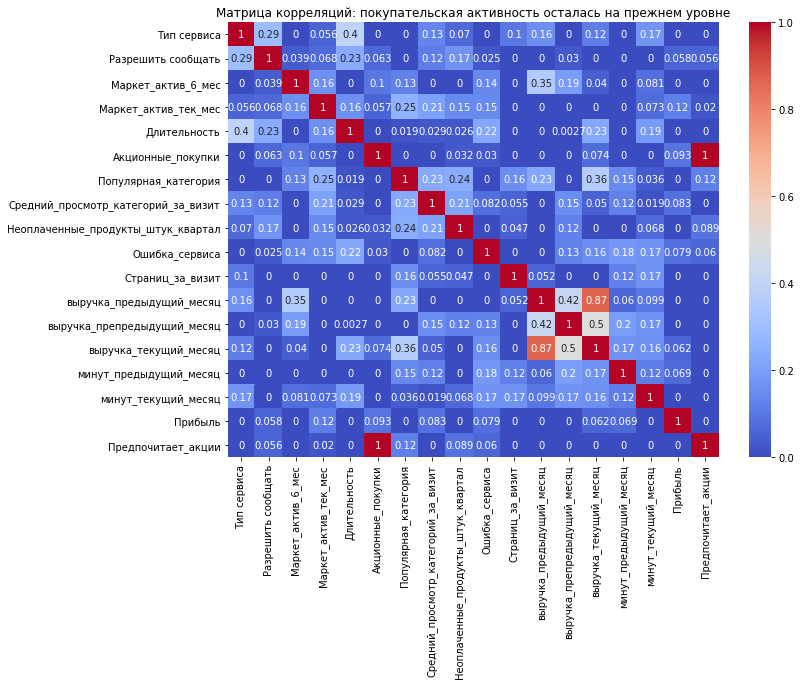

In [37]:
plt.figure(figsize = (11,8))
sns.heatmap(full_df[full_df['Покупательская активность']=='Прежний уровень'].
            drop(columns=['id','Покупательская активность']).
            phik_matrix(interval_cols=interval_cols),annot = True,cmap='coolwarm')
plt.title('Матрица корреляций: покупательская активность осталась на прежнем уровне')

plt.show()

Взаимосвязь между выручкой в текущем месяце и предыдущем месяца достаточно сильна. Для избежания мультиколлинеарности, уберем переменную *выручка_предыдущий_месяц*.

Кроме того, исключим переменную *Акционные_покупки*. Как мы выяснили ранее, переменная имеет нелинейных характер и логика лучше описывается бинарной переменной *Предпочитает_акции*.

In [38]:
full_df = full_df.drop(['Акционные_покупки'],axis = 1)
full_df = full_df.set_index('id')

Итак, мы видим, что для обеих категорий целевых категорий структура корреляций в целом схожа - между большинством переменных корреляция довольно слабая.  
В то же время, для клиентов, у которых снизилась активность, видны более сильные связи между переменными описывающими выручку, количество просмотренных страниц за визит и время, проведенное на сайте. Более точное влияние признаком мы узнаем во время построения моделей.
 
Кроме этого, для избежания мультиколлинеарности мы удалили переменную *Акционные_покупки*, которая полностью связана с новой переменной  *Предпочитает акции*.

## Построение моделей с использованием пайплайнов

In [39]:
# Перед построением пайплайна определим категории колонок в датафрейма

ohe_columns = [
    'Тип сервиса', \
    'Разрешить сообщать',\
    'Предпочитает_акции',\
    'Популярная_категория'
]

ord_columns = ['Тип сервиса']

num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',\
       'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',\
       'выручка_предыдущий_месяц',
       'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_препредыдущий_месяц',\
       'выручка_текущий_месяц', 'минут_предыдущий_месяц',\
       'минут_текущий_месяц', 'Прибыль'] 

Добавим шаг с OneHotEncoding для категориальных переменных.
Как мы выяснили ранее, для всех таких признаков количество одного класса сильно превышает количество других, поэтому установим опцию "заполнять пропуски самым частым значением" - такое заполнение будет правдоподобным.

Для признака "тип сервиса" попробуем применить Ordinal Encoder, так как логично можно трактовать эту переменую как порядковую, где свервис премиум лучше сервиса стандарт.

In [40]:
#Опишем отдельные шаги пайплайна по обработке данных разных типов

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe_enc', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ordinal_pipe = Pipeline(
    [
        ('simpleImputer_ordinal_before', 
         SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
        
        ('ordinal_enc', OrdinalEncoder(handle_unknown='use_encoded_value',
                                  unknown_value=np.nan,
                                  categories = [['стандарт','премиум']])),
        
        ('simpleImputer_ordinal_after', 
         SimpleImputer(missing_values=np.nan,strategy='most_frequent'))
    ]
)

# Соберем пайплайн с предобработкой данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe,ohe_columns),
        ('ord', ohe_pipe,ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [41]:
# Соберем финальный пайплайн с предобработкой данных и построением модели
# Инициализируем какую-то модель, например решающее дерево, чтобы затем вместо нее при поиске гиперпатаметров 
# перебирать другие модели

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier())
    ]
) 

После создания схемы пайплайна опишем справочник всех комбинаций гиперпараметров:  
- Для модели KNeighborsClassifier() будем использовать только один гиперпараметр -  n_neigbours. На этапе исследовательского анализа мы избавились от всех аномальных значений, поэтому метрика расстояния по-умолчанию (по смыслу 'euclidean') нам подойдет;  
- Для модели DecisionTreeClassifier() будем использовать 3 гиперпараметра: max_depth, min_samles_split, min_samples_leaf;  
- Для модели SVC() ,также будем использовать 3 гиперпараметра: C и gamma, отвечающие за регуляризацию, а также kernel, отвечающий за варианты ядра;
- Для модели LogisticRegression() сразу зададим солвер 'saga' (совместимый с обоими видами регуляризации) и тип регуляризации 'elasticnet'. Далее в качестве гиперпараметров будем использовать силу регуляризации C и l1_ratio для elasticnet (по смыслу, если l1_ratio = 0 мы имеем l2 регуляризацию, если l1_ration = 1 - l1 регуляризацию).


Помимо параметров самих моделей, также будем перебирать варианты скалирования количественных переменных между StandardScaler(), MinMaxScaler() и passthrough (в модели DesisionTreeClassifier).

In [42]:
# Создадим словарь со всеми комбинациями гиперпараметров
RANDOM_STATE = 123


param_distributions = [
    # {
    #     'models': [KNeighborsClassifier()],
    #     'models__n_neighbors': range(1, 20),
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    # },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 9),
        'models__min_samples_split':range(2,4),
        'models__min_samples_leaf':range(1,3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel':['sigmoid','rbf'],
        'models__C':np.linspace(0.1,15,45),
        'models__gamma':np.linspace(0.1,15,45),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver = 'saga',
                                      penalty = 'elasticnet', max_iter = 500)],
        'models__l1_ratio':[0,0.25,0.5,0.75,1],      
        'models__C':np.linspace(0.1,5,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
] 

Теперь, после построения пайплайна и задания справочника гиперпараметров, нам необходимо провести поиск оптимальных гиперапараметров.

Далее необходимо выбрать целевую метрику, которую мы будем оптимизировать в ходе поиска гиперпараметров.
В целом, так как группы клиентов со стабильной и снизившейся покупательской активностью сопоставимы по размеру, метрика accuracy нам вполне подходит.Тем не менее, попробуем рассмотреть вопрос детальнее.  
В случае, если модель предсказывает снижение покупательской активности, ожидаемое действие от компании - создание персонализированного предложенияя. У нас нет данных об издержках создания такого предложения, но можно предположить, что такие издержки не нулевые и создать индивидуальные предложения всем клиентам невозможно (дорого). В то же время, создание персонального пердложения для покупателя со стабильной активностью явно не ухудшит его клиентский опыт, а создание персонального предложения для покупателя со снижающейся активностью может его удержать. Иными словами, кажется что обе ошибки False Positive и False Negative важны для компании. В связи с этим, предлагаем использовать их среднее гармоническое f1_score.

Прежде чем переходить к обучению модели, преобразуем целевую переменную с LabelEncoder. Лексикографический порядок доллжен обеспечить нам то, что "Снизилась" для целевого признака будет закодировано как 1, а "Прежний уровень" как 0.


In [44]:
%%time

RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    full_df.drop(['Покупательская активность'], axis=1),
    full_df['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = full_df['Покупательская активность'])

# Закодируем целевую переменную
lbl_encoder = LabelEncoder()
y_train = lbl_encoder.fit_transform(y_train)
y_test = lbl_encoder.transform(y_test)



randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring = {'accuracy_score':'accuracy', 'f1_score':'f1'} ,
    cv = 5,
    n_iter=150, # так как пространство гиперпараметров велико, мы предлагаем использоваться повышеное кол-во итераций
    random_state=RANDOM_STATE, 
    n_jobs=-1,
    #error_score = 'raise',
    refit = 'f1_score'
)

randomized_search.fit(X_train, y_train)

CPU times: user 2min 2s, sys: 239 ms, total: 2min 2s
Wall time: 2min 2s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe_enc',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Тип '
                                                                                'сервиса',
                                                                                'Разрешить '
                                                                                'сообщать',
                                                                                'Предпочитает_акции...
                                        {'models': [LogisticRegression(max_iter=500,
                                                                       penalty='elasticnet',
                                                                       random_state=123,
                                                                       solver='saga')],
                                         'models__C': array([0.1 , 0.45, 0.8 , 1.15, 1.5 , 1.85, 2.2 , 2.55, 2.9 , 3.25, 3.6 ,
       3.95, 4.3 , 4.65, 5.  ]),
                                         'models__l1_ratio': [0, 0.25, 0.5,
                                                              0.75, 1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, refit='f1_score',
                   scoring={'accuracy_score': 'accuracy', 'f1_score': 'f1'})

In [45]:
print(f'F1_score of the best model is {round(randomized_search.best_score_,3)}')
randomized_search.best_params_

F1_score of the best model is 0.817


{'preprocessor__num': MinMaxScaler(),
 'models__l1_ratio': 0.75,
 'models__C': 0.45000000000000007,
 'models': LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123,
                    solver='saga')}

In [46]:
(pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_f1_score')
[['param_preprocessor__num','param_models','params',
  'rank_test_f1_score','rank_test_accuracy_score',
  'mean_test_f1_score','mean_test_accuracy_score']]).head(3)

,param_preprocessor__num,param_models,params,rank_test_f1_score,rank_test_accuracy_score,mean_test_f1_score,mean_test_accuracy_score
10,MinMaxScaler(),"LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123,\n solver='saga')","{'preprocessor__num': MinMaxScaler(), 'models__l1_ratio': 0.75, 'models__C': 0.45000000000000007, 'models': LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123, solver='saga')}",1,1,0.817173,0.870357
84,MinMaxScaler(),"LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123,\n solver='saga')","{'preprocessor__num': MinMaxScaler(), 'models__l1_ratio': 0.75, 'models__C': 0.8, 'models': LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123, solver='saga')}",2,2,0.815495,0.869326
44,MinMaxScaler(),"LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123,\n solver='saga')","{'preprocessor__num': MinMaxScaler(), 'models__l1_ratio': 0.25, 'models__C': 1.1500000000000001, 'models': LogisticRegression(max_iter=500, penalty='elasticnet', random_state=123, solver='saga')}",3,3,0.814324,0.868300


Итак, мы провели поиск наилучшей модели среди всего заданного набора моделей и гиперпараметров для них.  
Наилучшей моделью с точки зрения выбранной метрики f1_score стала модель логистической регрессии, перед применением которой количесвтенные данные преобразуются с помощью MinMaxScaler().  
С точки зрения гиперпараметров, в модели используется Elasticnet регуляризация (линейная комбинация регуляризаций l1 и l2) с весом l1_ratio 0.75 - отдавая предпочтение типу регуляризации l1. Сила регуляризации определяется параметром С = 0.45.  
С точки зрения метрик, модель демонстрирует высокое значения метрики f1_score - 0.817. В то же время, мы дополнительно рассмотрели метрику accuracy - выбранная модель имеет значение 0.87. Примечательно, что выбранная модель является наилучшей с точки зрения метрики f1_score и также первой наилучшей с точки зрения accuracy_score.


## Анализ важности признаков

После выбора наилучшей модели мы можем перейти к анализу фаторов, влияющих на целевой признак.  
Воскользуемся библиотекой shap. Для начала выделим отдельно наилушую моделт и наилуший способ трансформации данных.

In [47]:
best_model = randomized_search.best_estimator_.named_steps['models']
best_transformer = randomized_search.best_estimator_.named_steps['preprocessor']

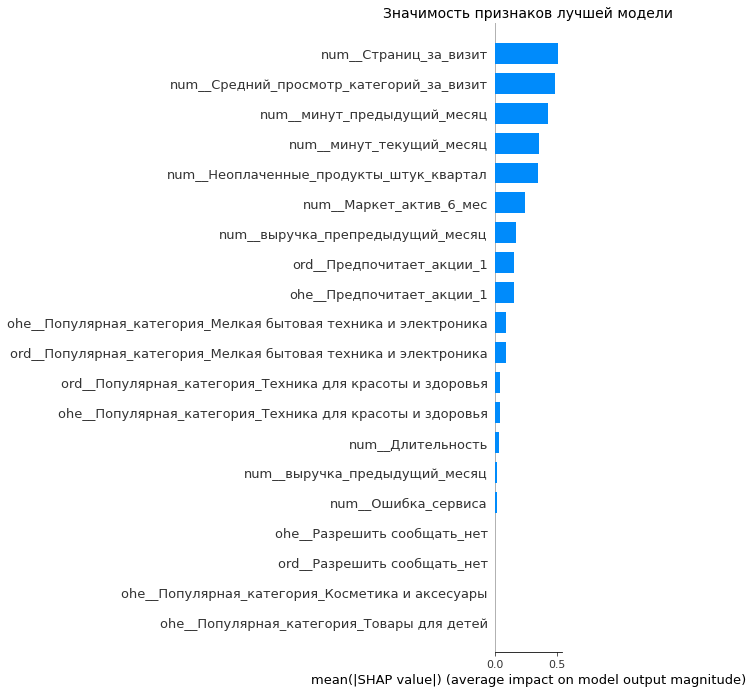

In [48]:
# Построим график значимости признаков
x_Train = best_transformer.fit_transform(X_train)
x_Test = best_transformer.transform(X_test)

x_Train = pd.DataFrame(x_Train, columns = best_transformer.get_feature_names_out())
x_Test = pd.DataFrame(x_Test,columns = best_transformer.get_feature_names_out())

explainer = shap.LinearExplainer(best_model, x_Train)
#explainer = shap.KernelExplainer(best_model.predict_proba, x_Train)

shap_values = explainer(x_Test)
shap.summary_plot(shap_values, x_Test, plot_type="bar", show=False)
plt.title("Значимость признаков лучшей модели", fontsize = 14)
plt.show()

Благодаря тому, что в оптимальной модели частично используется l1 регуляризация в ходе обучения модели алгоритм сам отделил признаки, которые оказывают наименьшее влияние и прктически занулил их. К таким переменным можно отнести Ошибка_сервиса и Тип сервиса.  

В сво очередь, среди остальных признаков нибольшее влияние оказывают переменные, связанные с присутствием пользователя на сайте: сколько страниц просматривал, сколько категорий просматривал, сколько минут провел на сайте в этом/ в предыдущем месяце, сколько рекламных коммуникаций получал.

Далее мы рассмотрим направление влияния признаков на отнесение клиентов в тем, у кого снизится потребительская активность.

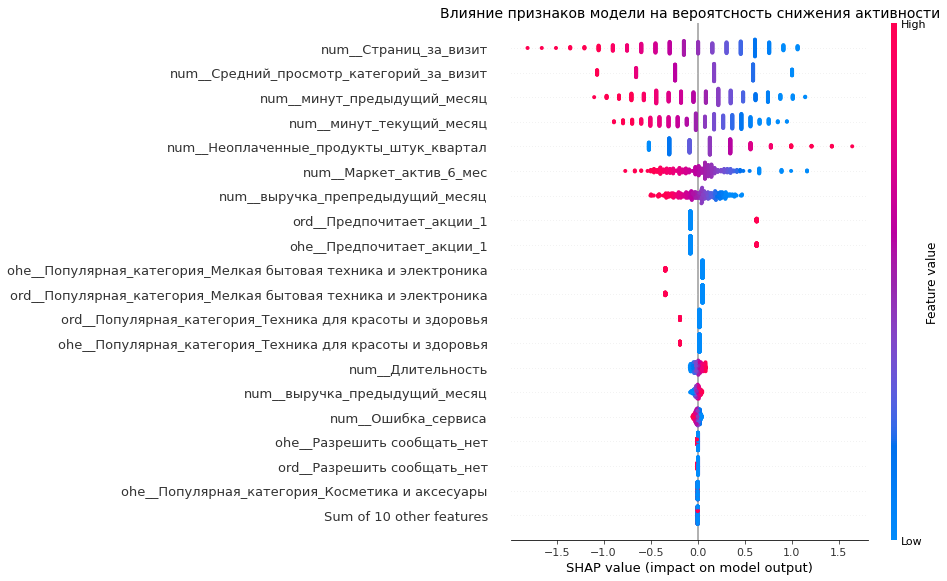

In [49]:
shap.plots.beeswarm(shap_values, max_display = 20, show = False)
plt.title('Влияние признаков модели на вероятсность снижения активности', fontsize = 14)
plt.show()

С помощью данного графика мы можем анализировать не только силу, но и направления влияния факторов на целевую переменную.  
Рассмотрим более детально.  
Для первых 5 переменных, которые близки по смыслу, мы видим одинаково направленную логичную взимосвязь переменных. Вероятность того, что активность клиента снизится, снижается, если у него:  
- большое количество посещаемых страниц за визит
- большое количество просмотренных категорий за визит
- долгое время, проведенное на сайте в текущем и предыдущем месяцах  
- большое количество маркетинговых коммуникаций за предыдущие 6 месяцев

Эти взаимосвязи логичны, они отражают общую интуитивно понятную бизнес логику "чем больше клиент взаимодействует с сайтом, тем больше он вовлечен и тем выше его активность".
На основе этих данных можно принимать бизнес-решения о проведении маркетинговых компаний, направленных на повышение проводимого на сайте времени. Также можно принять решение об инвестировании в разработку улучшенной рекомендательной системы, которая будет показывать интересные для клиента товары, тем самым заставляя его посещать больше страниц и категорий за визит.

В обратном направлении мы видим, например, следующие эффекты:  
- Неоплаченные товары в корзине повышают вероятность снижения активности  
- Если клиент предпочитает акции, у него тоже более высок шанс снижения активности  

Эти взаимосвязи также логичны, они отражают ситуации, в которых клиент либо не до конца удовлетворен качеством товара и рассматривает другие варианты (возможно на других площадках), либо не удовлетворен ценой (и, например, ждет акции на товар). Возможным бизнес решением в такой ситуации мог бы стать более внимательный мониторинг нахождения неоплаченных товаров в корзине. Далее,например, спустя неделю пребывания товара в корзине, можно предложить клиенту символическую скидку (акцию).

Наконец, влияние Ошибок сервиса крайне мало на активность пользователя. Отсюда можно сделать вывод, что на настоящий момент компании не следует вкладывать крупные инвестиции в технологические улучшеня, все и так работает неплохо. Также, тип сервиса оказывает малое влияние на активность клиентов, возможно условия пакетов не совсем отражают потребности пользователей и нуждаются в пересмотре. Также примечательно, что маркетинговая активность в текущем месяце оказывает мало влияния на вероятность снижения активности.

## Сегментация покупателей

Для проведения сегментации расмотрим прибыльность клиентов для компании (как основной показатель ценности клиента) и вероятность снижения активности.

In [50]:
# Для начала добавим в набор данных с признаками предсказанные вероятности снижения активности
dfd = pd.concat([x_Test,
           pd.DataFrame(best_model.predict_proba(x_Test.values)[:,1],
          columns = ['y_proba'])],axis=1)

In [51]:
# Определим первый квартиль как клиентов с низкой прибыльностью,
# на которых мы не хотим концентрироваться в первую очередь
dfd['num__Прибыль'].describe()

count    325.000000
mean       0.487525
std        0.161103
min        0.000000
25%        0.377953
50%        0.503937
75%        0.592126
max        1.034646
Name: num__Прибыль, dtype: float64

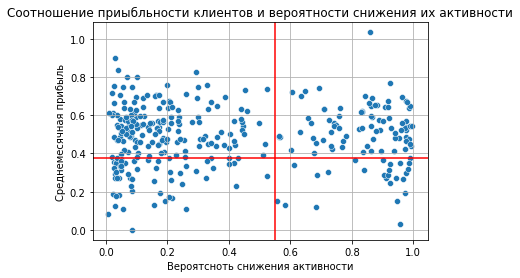

In [52]:
sns.scatterplot(data = dfd, x = 'y_proba',y = 'num__Прибыль')

plt.xlabel('Вероятсноть снижения активности')
plt.ylabel('Среднемесячная прибыль')
plt.title('Соотношение приыбльности клиентов и вероятности снижения их активности')

#Рассмотрим примерные пороговые значения для выделения сегментов
plt.axhline(y = 0.378, color = 'red') # 25% персентиль 
plt.axvline(x = 0.55, color = 'red') # визуальная область, где наиболее четко происходит разделение вероятностей

plt.grid()
plt.show()

В целом мы видим, что основная масса клиентов довольно четко разделилась на тех, у кого активность почти наверняка останется неизменной и тех, у кого активность почти наверняка снизится.  
Для выделения сегмента, активность которого мы хотим поддержать на высоком уровне, прежде всего установим условные границы для тех клиентов, которых мы хотим анализировать.  
Так, например, мы предлагаем в первую очередь сконцентрировтаься на клиентах с большой вероятностью снижения активности (предлагаем границу 0.55 так как визуально примерно в этой области происходит разделение между наблюдениями), а также предлагаем не рассматривать четверь клиентов, приносящих самую низкую прибыль (рассмотрим в качестве границы 25 персентиль, равный в отмаштабированной переменной 0.378).


На этапе анализа важности признаков модели мы увидели, что клиенты, предпочитающие товары по акции имеют повышенный шанс снижения активности. Рассмотрим, как они расположены на грфике прибыльности и вероятности снижения активности.

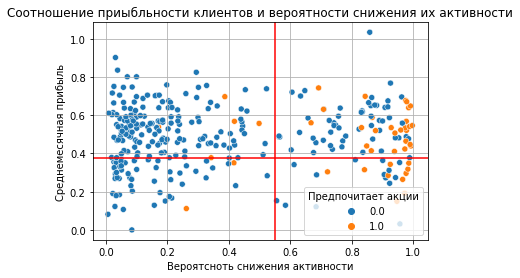

In [53]:
sns.scatterplot(data = dfd, x = 'y_proba',y = 'num__Прибыль', hue = 'ohe__Предпочитает_акции_1')

plt.xlabel('Вероятсноть снижения активности')
plt.ylabel('Среднемесячная прибыль')
plt.title('Соотношение приыбльности клиентов и вероятности снижения их активности')

plt.axhline(y = 0.378, color = 'red')
plt.axvline(x = 0.55, color = 'red')

plt.legend(title = 'Предпочитает акции', loc = 'lower right')
plt.grid()
plt.show()

Итак, мы действительно видим, что в интересующей нас области находится большое количество клиентов, предпочитающих товары по акции. Выделим таких клиентов и прочих в отдельные датафреймы.

In [54]:
df_auc = dfd[(dfd['num__Прибыль']>=0.378)&
             (dfd['y_proba']>=0.55)&
             (dfd['ohe__Предпочитает_акции_1']==1)].copy()
df_non_auc = dfd[~((dfd['num__Прибыль']>=0.378)&
             (dfd['y_proba']>=0.55)&
             (dfd['ohe__Предпочитает_акции_1']==1))].copy()

Согласно предсказаниям модели, наиболее значимымы факторами, влияющими на вероятность снижения активности являются показатели взаимодействия с платформой, нам нужно заинтересовать таких клиентов проводить больше времени на сайте, просматривать больше страниц и категорий товаров. Другим значимым фактором является количество неоплаченных товаров в корзине.  

Посмотрим, как сейчас распределено количество маркетинговых коммуникаций, неоплаченных товаров в корзине, количество страниц за визит, количество минут проведенных на сайте.

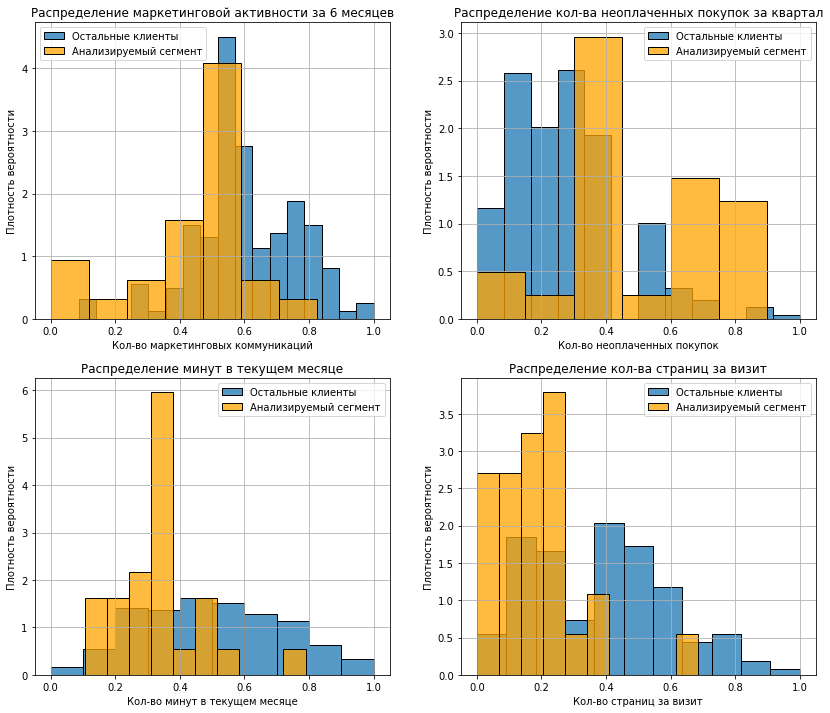

In [55]:
fix, axes = plt.subplots(2,2,figsize = (14,12))


sns.histplot(data = df_non_auc, x = 'num__Маркет_актив_6_мес', label = 'Остальные клиенты',
             ax = axes[0,0], stat='density', common_norm=False)
sns.histplot(data = df_auc, x = 'num__Маркет_актив_6_мес', color = 'orange',
             label = 'Анализируемый сегмент', ax = axes[0,0], stat='density', common_norm=False)
axes[0,0].legend()

axes[0,0].set_xlabel('Кол-во маркетинговых коммуникаций')
axes[0,0].set_ylabel('Плотность вероятности')
axes[0,0].set_title('Распределение маркетинговой активности за 6 месяцев')
axes[0,0].grid()

sns.histplot(data = df_non_auc, x = 'num__Неоплаченные_продукты_штук_квартал', label = 'Остальные клиенты',
             ax = axes[0,1], stat='density', common_norm=False)
sns.histplot(data = df_auc, x = 'num__Неоплаченные_продукты_штук_квартал', color = 'orange',
             label = 'Анализируемый сегмент', ax = axes[0,1], stat='density', common_norm=False)
axes[0,1].legend()

axes[0,1].set_xlabel('Кол-во неоплаченных покупок')
axes[0,1].set_ylabel('Плотность вероятности')
axes[0,1].set_title('Распределение кол-ва неоплаченных покупок за квартал')
axes[0,1].grid()

sns.histplot(data = df_non_auc, x = 'num__Страниц_за_визит', label = 'Остальные клиенты',
             ax = axes[1,1], stat='density', common_norm=False)
sns.histplot(data = df_auc, x = 'num__Страниц_за_визит', color = 'orange',
             label = 'Анализируемый сегмент', ax = axes[1,1], stat='density', common_norm=False)
axes[1,1].legend()

axes[1,1].set_xlabel('Кол-во страниц за визит')
axes[1,1].set_ylabel('Плотность вероятности')
axes[1,1].set_title('Распределение кол-ва страниц за визит')
axes[1,1].grid()


sns.histplot(data = df_non_auc, x = 'num__минут_текущий_месяц', label = 'Остальные клиенты',
             ax = axes[1,0], stat='density', common_norm=False)
sns.histplot(data = df_auc, x = 'num__минут_текущий_месяц', color = 'orange',
             label = 'Анализируемый сегмент', ax = axes[1,0], stat='density', common_norm=False)
axes[1,0].legend()

axes[1,0].set_xlabel('Кол-во минут в текущем месяце')
axes[1,0].set_ylabel('Плотность вероятности')
axes[1,0].set_title('Распределение минут в текущем месяце')
axes[1,0].grid()

plt.show()

Мы действительно видим, что у клиентов, которые предпочитают покупки по акции, наблюдается меньшее маркенговых коммуникаций, они проводят меньше времени на сайте, просматривают меньше страниц за визит, имеют большее количество неоплаченных товаров в корзине. 

На основе этого, мы хотим предложить комплексный подход к удержанию уровня активности таких клиентов. Мы не можем заставить их напрямую проводить больше времени на сайте, но мы должны приложить косвенные усилия, чтобы добиться этого:  
- Через увеличение количества маркетинговых коммуникаций мы можем предлагать им большее количество товаров (в том числе товаров по акции), тем самым одновременно и повышая их время нахождения на сайте, и повышая количество просматриваемых ими страниц. 
- Помимо похожих товаров, необходимо предлагать товары комплементы из других категорий, тем самым увеличивая количество просматриваемых категорий.  
- Когда мы видим, что у клиентов скапливается большое количество неоплаченных товаров в корзине, мы можем предлагать им дополнительные скидки (акции) на эти товары, тем повышая вероятность, что клиент их все таки купит, проведет больше времени на сайте, получит позитивный клиентский опыт от предоставленной скидки.

## Общий вывод

В рамках данного проекта мы построили модель, с помощью которой интернет-магазин "В один клик" может определять клиентов, по которым есть риск снижения покупательской активности. Более того, мы предложили вариант сегментации клиентов и пример анализа, как можно повысить вовлеченность клиентов.  

Работа была проведена в несколько этапов:  
- прежде всего мы собрали все предоставленные данные (данные о поведении на сайте, о продуктовом поведении, о финансовом поведении, а также о коммуникации с клиентом) и провели предобработку данных. В ходе предобработки мы удостоверелись, что в данных корректные форматы, отсутствуют пропуски, отсутствуют явные дубликаты, а также исправили 10 неявных дубликтов.
- Затем, мы провели исследовательский анализ данных, в рамках которого обнаружили и удалили аномальное значение выручки по клиенту за текущий период, обнаружили и учли нелинейный характер переменной "акционные покупки",а также удалили данные о клиентах с покупательской активностью менее 3-х месяцев (3 клиента).  
- Далее мы провели корреляционный анализ, в ходе которого обнаружили, что характер корреляций неоднороден между клиентами, у которых покупательская активность снизилась и у которых осталась на прежнем уровне. Кроме того, удалили два признака для избежания мульиколлинеарности.
- После этого мы перешли к построению модели классификации.

В ходе поиска лучшей модели мы выбирали среди следующих типов моделей:
- Логистическая регрессия
- Метод опорных векторов
- К ближайших соседей
- Решающее дерево

Для каждой из моделей мы определи широкий набор гиперпараметров.  
Кроме этого, для мы применили несколько вариантов масштабирования количественных переменных (MinMaxScaler, StandardScaler).

Для поиска оптимальной модели мы использовали метрику f1_score исходя из того, что оба типа ошибок False Positive и False Negative несут дополнительные финансовые изержки для интернет-магазина, и хотелось бы их минимизировать.

Далее путем перебора 150 случайных моделей и параметризаций мы подобрали наилучшую модель.

Наилучшей моделью стала модель логистической регрессии с Elasticnet регуляризацей с весом l1_ratio = 0.75 - отдающим предпочтение типу регуляризации l1. Сила регуляризации определяется параметром С = 0.45.  
Модель демонстрирует высокое значения метрики f1_score - 0.817, а также метрики accuracy, равной 0.87.  

Согласно наилучшей модели, нибольшее влияние оказывают переменные, связанные с присутствием пользователя на сайте: сколько страниц просматривал, сколько категорий просматривал, сколько минут провел на сайте в этом/ в предыдущем месяце, сколько рекламных коммуникаций получал. Эти взаимосвязи логичны, они отражают общую интуитивно понятную бизнес логику "чем больше клиент взаимодействует с сайтом, тем больше он вовлечен и тем выше его активность"

Наиболее склонными к снижению активности оказались пользователи с высоким количеством неоплаченных товаров в корзине, а также предпочетающие покупать товары по акции. Эти взаимосвязи также логичны, они отражают ситуации, в которых клиент либо не до конца удовлетворен качеством товара и рассматривает другие варианты (возможно на других площадках), либо не удовлетворен ценой (и, например, ждет акции на товар).  


Ряд переменных оказал незначительное влияние. Например, влияние Ошибок сервиса крайне мало на активность пользователя. Также, тип сервиса оказывает малое влияние на активность клиентов, возможно условия пакетов не совсем отражают потребности пользователей и нуждаются в пересмотре.

Для предметного анализа мы выбрали сегмент клиентов, находящихся выше первого квартиля по показателю прибыльности и предпочитающих товары по акции, для которых модель предсказали крайне высокую вероятность снижения активности. Мы выяснили, что сейчас подавляющее большинство клиентов, предпочитающих товары по акции, имеют высокую вероятность снижения активности. В то же время, такие клиенты получают меньшее маркенговых коммуникаций чем все остальные, они проводят меньше времени на сайте, просматривают меньше страниц за визит, имеют большее количество неоплаченных товаров в корзине. 

На основе этого, мы хотим предложить комплексный подход к удержанию уровня активности таких клиентов:  
- Через увеличение количества маркетинговых коммуникаций мы можем предлагать им большее количество товаров (в том числе товаров по акции), тем самым одновременно и повышая их время нахождения на сайте, и повышая количество просматриваемых ими страниц. 
- Помимо похожих товаров, необходимо предлагать товары комплементы из других категорий, тем самым увеличивая количество просматриваемых категорий.  
- Когда мы видим, что у клиентов скапливается большое количество неоплаченных товаров в корзине, мы можем предлагать им дополнительные скидки (акции) на эти товары, тем повышая вероятность, что клиент их все таки купит, проведет больше времени на сайте, получит позитивный клиентский опыт от предоставленной скидки.


In [ ]:
# Ссылка на гитхаб репозиторий
https://github.com/Sburok/Git_project.git